## Setup

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle
import matplotlib.cm as cm
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [87]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

In [88]:
def human_format2(num):
    for unit in ['', 'K', 'M', 'B']:
        if abs(num) < 1000:
            return f"{num:.0f}{unit}"
        num /= 1000
    return f"{num:.1f}T"

## Import data

In [89]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,23,177.13,7.70
104934,wood black board ant white finish,2011-12-06,4,31.80,7.95
104935,wood black board ant white finish,2011-12-07,70,484.50,6.92
104936,wood black board ant white finish,2011-12-08,226,1142.34,5.05


In [90]:
COMMON_DIR = '../../dataset/explanatory_variables'

uk_daily_cci = (
    pd.read_json(os.path.join(COMMON_DIR, 'cci.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_cpi = (
    pd.read_json(os.path.join(COMMON_DIR, 'cpi.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_interest_rate = (
    pd.read_json(os.path.join(COMMON_DIR, 'interest_rate.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_public_holidays = (
    pd.read_json(os.path.join(COMMON_DIR, 'public_holidays.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_unemployment = (
    pd.read_json(os.path.join(COMMON_DIR, 'unemployment.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)

## Analysis

### Retail data

In [91]:
summary_stats = online_retail_df.groupby('Description')['UnitsSold'].agg([
    'count', 'mean', 'std', 'min', 'max', lambda x: (x == 0).sum()
]).rename(columns={'<lambda_0>': 'zero_days'})
summary_stats.describe()

,count,mean,std,min,max,zero_days
count,142.0,142.000000,142.000000,142.0,142.000000,142.000000
mean,739.0,28.536574,63.917006,0.0,921.725352,247.028169
std,0.0,25.180706,62.296533,0.0,1224.868018,51.981986
min,739.0,2.228687,3.478613,0.0,33.000000,136.000000
25%,739.0,13.524019,30.214348,0.0,330.000000,211.500000
50%,739.0,21.346414,46.179953,0.0,530.500000,251.500000
75%,739.0,35.037212,77.004505,0.0,969.750000,283.000000
max,739.0,149.036536,437.797539,0.0,10048.000000,360.000000


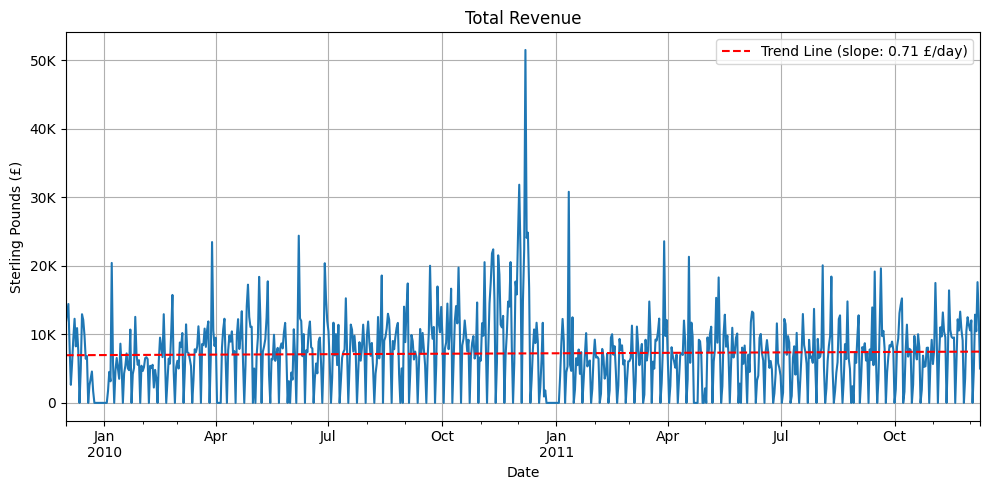

In [121]:
daily_revenue = online_retail_df.groupby('Date')['RevenuePounds'].sum().reset_index()
X = daily_revenue['Date'].map(lambda x: x.toordinal()).values.reshape(-1, 1)  # Convert dates to ordinal
y = daily_revenue['RevenuePounds'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

slope = model.coef_[0]
slope_str = f"{slope:.2f}"

fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['RevenuePounds'].sum().plot(ax=ax, label='')

ax.plot(daily_revenue['Date'], y_pred, linestyle='--', color='red', label=f'Trend Line (slope: {slope_str} £/day)')

ax.set_title('Total Revenue')
ax.set_xlabel('Date')
ax.set_ylabel('Sterling Pounds (£)')
ax.grid(True)
ax.legend()
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

In [119]:
y_pred

array([6959.61265077, 6960.32354813, 6961.03444548, 6961.74534284,
       6962.4562402 , 6963.16713755, 6963.87803491, 6964.58893227,
       6965.29982962, 6966.01072698, 6966.72162434, 6967.43252169,
       6968.14341905, 6968.85431641, 6969.56521376, 6970.27611112,
       6970.98700848, 6971.69790583, 6972.40880319, 6973.11970055,
       6973.8305979 , 6974.54149526, 6975.25239262, 6975.96328997,
       6976.67418733, 6977.38508469, 6978.09598204, 6978.8068794 ,
       6979.51777676, 6980.22867411, 6980.93957147, 6981.65046883,
       6982.36136618, 6983.07226354, 6983.7831609 , 6984.49405825,
       6985.20495561, 6985.91585297, 6986.62675032, 6987.33764768,
       6988.04854504, 6988.75944239, 6989.47033975, 6990.18123711,
       6990.89213446, 6991.60303182, 6992.31392918, 6993.02482653,
       6993.73572389, 6994.44662125, 6995.1575186 , 6995.86841596,
       6996.57931332, 6997.29021067, 6998.00110803, 6998.71200539,
       6999.42290274, 7000.1338001 , 7000.84469746, 7001.55559

In [93]:
df = online_retail_df[['Date', 'UnitsSold', 'RevenuePounds']]

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df.loc[:,'DayOfWeek'] = df['Date'].dt.day_name()
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=day_order, ordered=True)

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df.loc[:, 'Month'] = df['Date'].dt.month_name()

df.loc[:, 'Year'] = df['Date'].dt.year

def sort_year_month(series):
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    year_month_list = series.unique()
    # Parse each YearMonth string into (year, month_index) for sorting
    sortable_list = []
    for ym in year_month_list:
        year, month_name = ym.split('-')
        month_index = month_order.index(month_name)
        sortable_list.append((int(year), month_index, ym))
    sortable_list.sort()
    return [ym for year, month_index, ym in sortable_list]

df['YearMonth'] = df['Year'].astype(str) + '-' + df['Month']
ordered_year_months = sort_year_month(df['YearMonth'])
df['YearMonth_Ordered'] = pd.Categorical(df['YearMonth'], categories=ordered_year_months, ordered=True)

df

,Date,UnitsSold,RevenuePounds,DayOfWeek,Month,Year,YearMonth,YearMonth_Ordered
0,2009-12-01,45,29.90,Tuesday,December,2009,2009-December,2009-December
1,2009-12-02,87,61.75,Wednesday,December,2009,2009-December,2009-December
2,2009-12-03,34,23.40,Thursday,December,2009,2009-December,2009-December
3,2009-12-04,84,55.25,Friday,December,2009,2009-December,2009-December
4,2009-12-05,0,0.00,Saturday,December,2009,2009-December,2009-December
...,...,...,...,...,...,...,...,...
104933,2011-12-05,23,177.13,Monday,December,2011,2011-December,2011-December
104934,2011-12-06,4,31.80,Tuesday,December,2011,2011-December,2011-December
104935,2011-12-07,70,484.50,Wednesday,December,2011,2011-December,2011-December
104936,2011-12-08,226,1142.34,Thursday,December,2011,2011-December,2011-December


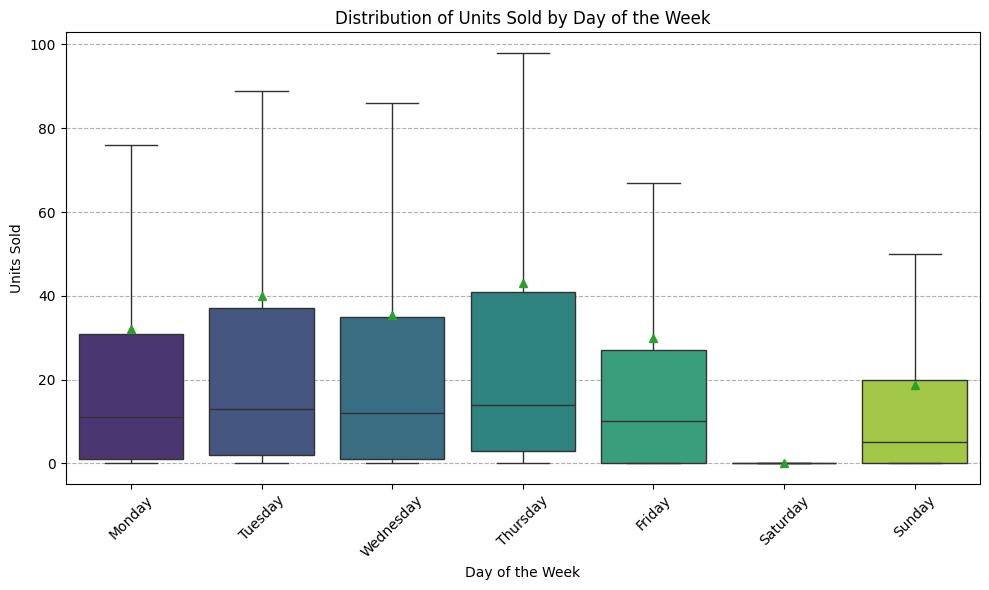

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
Monday,14910.0,32.142790,85.491557,0.0,1.0,11.0,31.0,2724.0
Tuesday,15052.0,40.054212,134.123362,0.0,2.0,13.0,37.0,10048.0
Wednesday,15052.0,35.470037,80.830983,0.0,1.0,12.0,35.0,1776.0
Thursday,15052.0,43.054013,134.966690,0.0,3.0,14.0,41.0,6528.0
Friday,15052.0,29.873040,79.668613,0.0,0.0,10.0,27.0,2989.0
Saturday,14910.0,0.083434,1.870017,0.0,0.0,0.0,0.0,102.0
Sunday,14910.0,18.751777,45.314239,0.0,0.0,5.0,20.0,1321.0


In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='UnitsSold', data=df, order=day_order, palette='viridis', showfliers=False, showmeans=True)
plt.title('Distribution of Units Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
df.groupby('DayOfWeek')['UnitsSold'].describe()

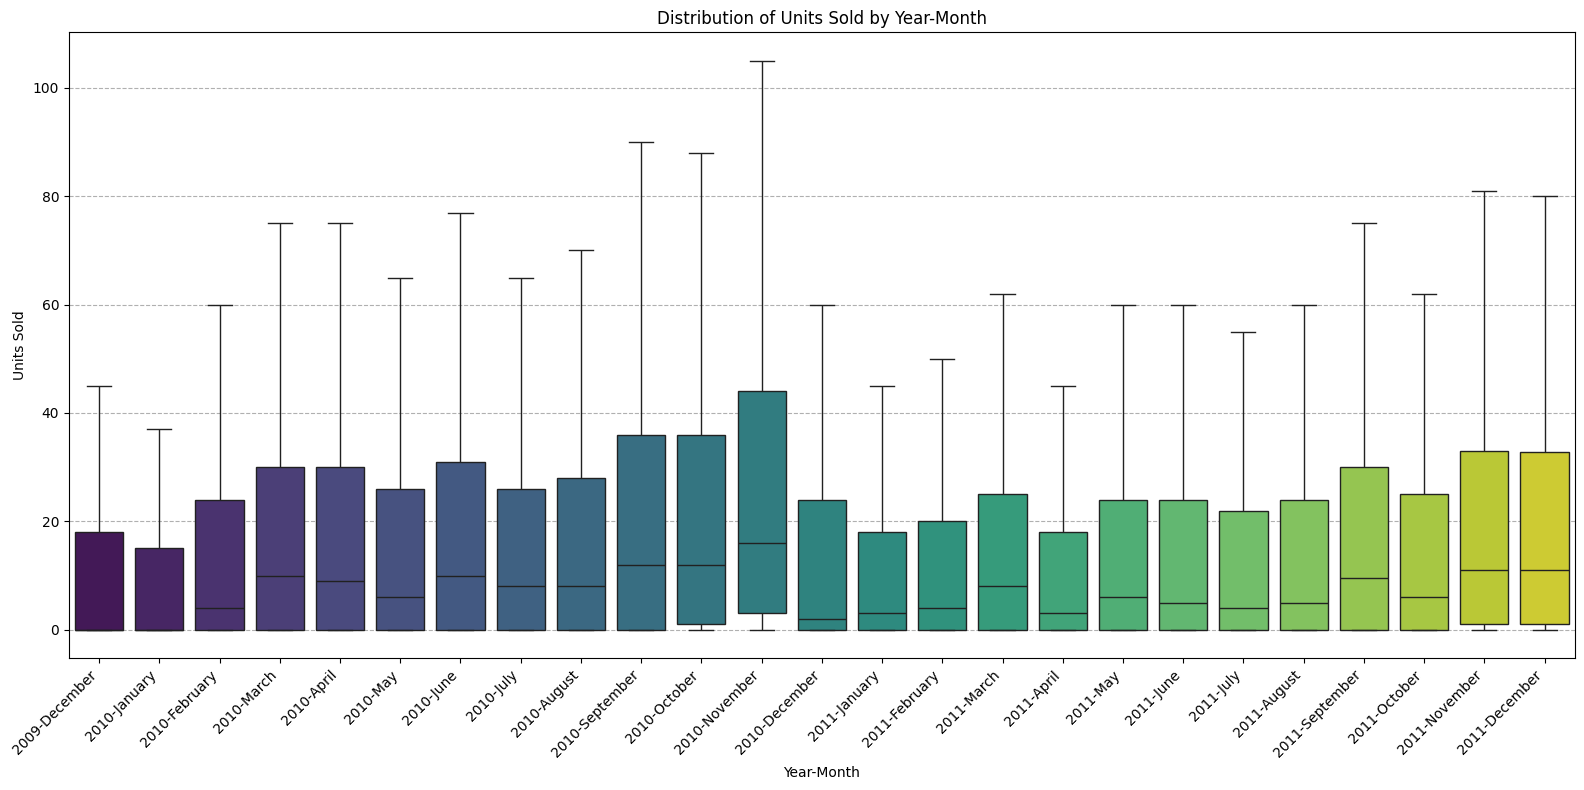

,count,mean,std,min,25%,50%,75%,max
YearMonth,,,,,,,,
2009-December,4402.0,23.274875,93.437017,0.0,0.0,0.0,18.00,4322.0
2010-April,4260.0,30.308216,69.639555,0.0,0.0,9.0,30.00,1200.0
2010-August,4402.0,31.289641,82.042925,0.0,0.0,8.0,28.00,2362.0
2010-December,4402.0,34.406406,159.923253,0.0,0.0,2.0,24.00,6528.0
2010-February,3976.0,24.865443,67.071525,0.0,0.0,4.0,24.00,1587.0
2010-January,4402.0,21.954339,66.435232,0.0,0.0,0.0,15.00,1193.0
2010-July,4402.0,26.402090,55.722848,0.0,0.0,8.0,26.00,759.0
2010-June,4260.0,34.232160,102.844804,0.0,0.0,10.0,31.00,2654.0
2010-March,4402.0,33.143571,167.887585,0.0,0.0,10.0,30.00,10048.0


In [95]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='YearMonth', y='UnitsSold', data=df, palette='viridis', showfliers=False)
plt.title('Distribution of Units Sold by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Units Sold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
df.groupby('YearMonth')['UnitsSold'].describe()

In [122]:
total_units_sold_by_product = online_retail_df.groupby('Description')['UnitsSold'].sum().sort_values(ascending=False)

p1 = total_units_sold_by_product.quantile(0.1)
p90 = total_units_sold_by_product.quantile(0.9)

bottom_products = total_units_sold_by_product[lambda x: x <= p1]
mid_products = total_units_sold_by_product[lambda x: (p1 < x) & (x < p90)]
top_products = total_units_sold_by_product[lambda x: x >= p90]

bottom_sample = list(np.random.choice(bottom_products.index, size=1))
mid_sample = list(np.random.choice(mid_products.index, size=2))
top_sample = list(np.random.choice(top_products.index, size=1))

product_sample = bottom_sample + mid_sample + top_sample
product_sample

['four hook white lovebirds',
 'feltcraft 6 flower friends',
 'ivory hanging decoration heart',
 'assorted colour bird ornament']

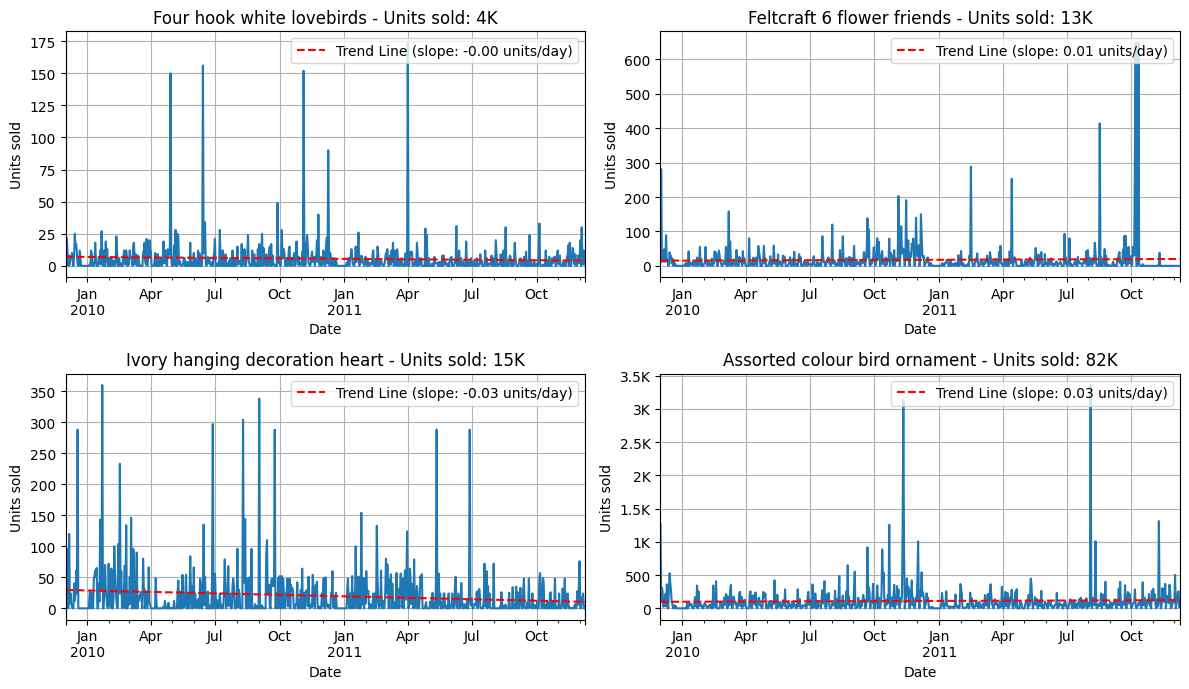

In [123]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    data.plot(ax=ax, label='')

    X = data.index.map(lambda x: x.toordinal()).values.reshape(-1, 1)
    y = data.values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    slope = model.coef_[0]
    slope_str = f"{slope:.2f}"

    ax.plot(data.index, y_pred, linestyle='--', color='red', label=f'Trend Line (slope: {slope_str} units/day)')

    ax.set_title(f'{product.capitalize()} - Units sold: {human_format2(total_sold)}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid()
    ax.legend(loc='upper right')
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

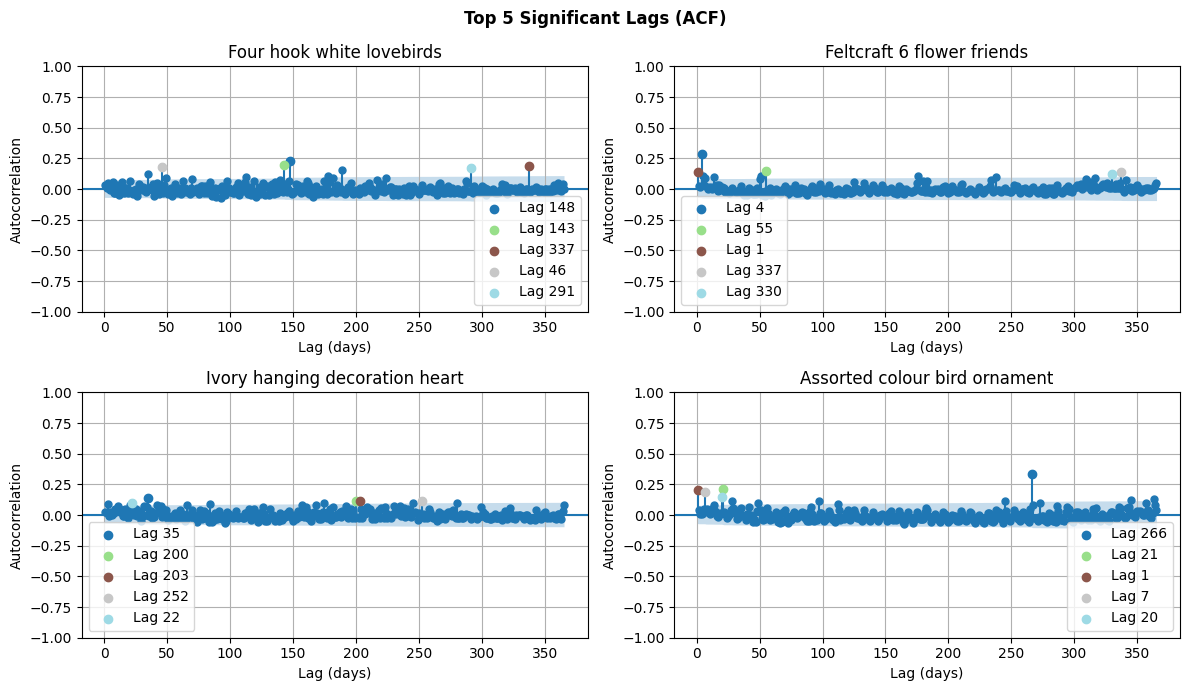

In [124]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
fig.suptitle('Top 5 Significant Lags (ACF)', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = (
        online_retail_df
        .query(f'Description == "{product}"')
        .set_index('Date')['UnitsSold']
        .sort_index()
    )

    lags = 365

    plot_acf(data, lags=lags, ax=ax, zero=False)

    acf_vals, confints = acf(data, nlags=lags, alpha=0.05)
    
    # Identify significant lags
    significant_lags = [
        (lag, acf_val)
        for lag, (acf_val, confint) in enumerate(zip(acf_vals[1:], confints[1:]), start=1)
        if confint[0] > 0 or confint[1] < 0
    ]

    # Sort by absolute autocorrelation and keep top 5
    top_lags = sorted(significant_lags, key=lambda x: abs(x[1]), reverse=True)[:5]

    colors = cm.get_cmap('tab20', len(top_lags))
    for i, (lag, acf_val) in enumerate(top_lags):
        ax.scatter(lag, acf_val, color=colors(i), label=f'Lag {lag}', zorder=5)

    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Autocorrelation')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

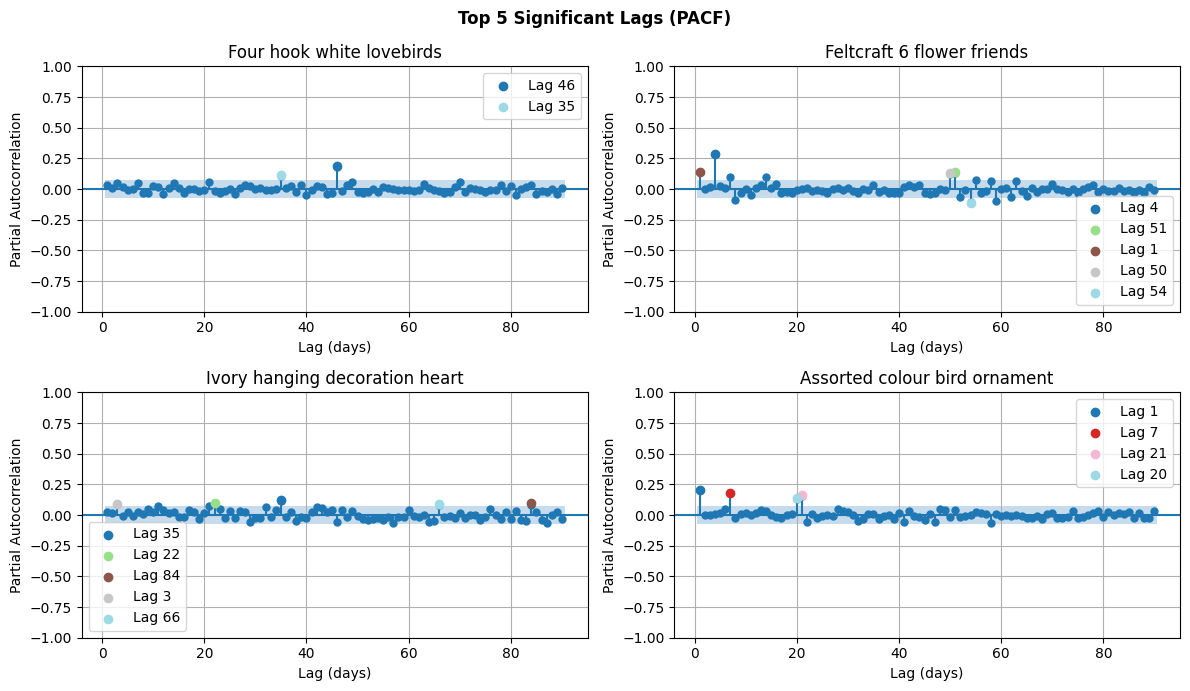

In [125]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
fig.suptitle('Top 5 Significant Lags (PACF)', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = (
        online_retail_df
        .query(f'Description == "{product}"')
        .set_index('Date')['UnitsSold']
        .sort_index()
    )

    lags = 90

    plot_pacf(data, lags=lags, ax=ax, zero=False)

    pacf_vals, confints = pacf(data, nlags=lags, alpha=0.05)
    
    # Identify significant lags
    significant_lags = [
        (lag, pacf_val)
        for lag, (pacf_val, confint) in enumerate(zip(pacf_vals[1:], confints[1:]), start=1)
        if confint[0] > 0 or confint[1] < 0
    ]

    # Sort by absolute PACF and keep top 5
    top_lags = sorted(significant_lags, key=lambda x: abs(x[1]), reverse=True)[:5]

    colors = cm.get_cmap('tab20', len(top_lags))
    for i, (lag, pacf_val) in enumerate(top_lags):
        ax.scatter(lag, pacf_val, color=colors(i), label=f'Lag {lag}', zorder=5)

    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Partial Autocorrelation')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

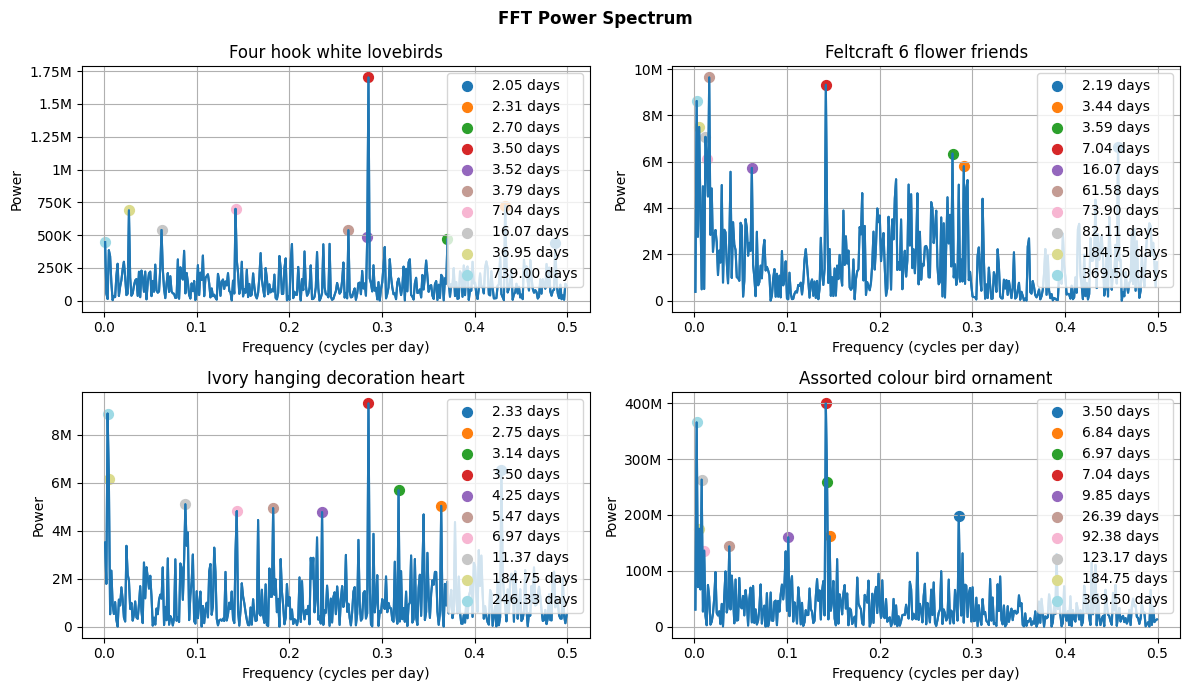

In [126]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('FFT Power Spectrum', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"') \
                           .set_index('Date')['UnitsSold'] \
                           .sort_index()

    # Ensure daily frequency and fill missing dates
    data = data.asfreq('D').fillna(0)

    # Compute FFT and frequencies
    n = len(data)
    fft_vals = np.fft.fft(data - data.mean())
    freqs = np.fft.fftfreq(n, d=1)  # d=1 for daily frequency

    # Take positive frequencies only
    pos_mask = freqs > 0
    freqs = freqs[pos_mask]
    power = np.abs(fft_vals[pos_mask])**2

    # Plot power vs. frequency
    ax.plot(freqs, power, color='tab:blue')

    # Plot power spectrum
    ax.plot(freqs, power, color='tab:blue')

    # Identify top 5 peaks
    top_indices = np.argsort(power)[-10:]  # indices of top 5 powers
    top_freqs = freqs[top_indices]
    top_powers = power[top_indices]
    top_periods = 1 / top_freqs

    sorted_items = sorted(zip(top_freqs, top_powers, top_periods), key=lambda x: x[2])  # sort by period
    
    # Use consistent coloring
    colors = cm.get_cmap('tab20', len(top_periods))

    for i, (f, p, T) in enumerate(sorted_items):
        ax.scatter(f, p, color=colors(i), s=50, label=f'{T:.2f} days')

    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('Frequency (cycles per day)')
    ax.set_ylabel('Power')
    ax.grid(True)
    ax.legend(loc='upper right')
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

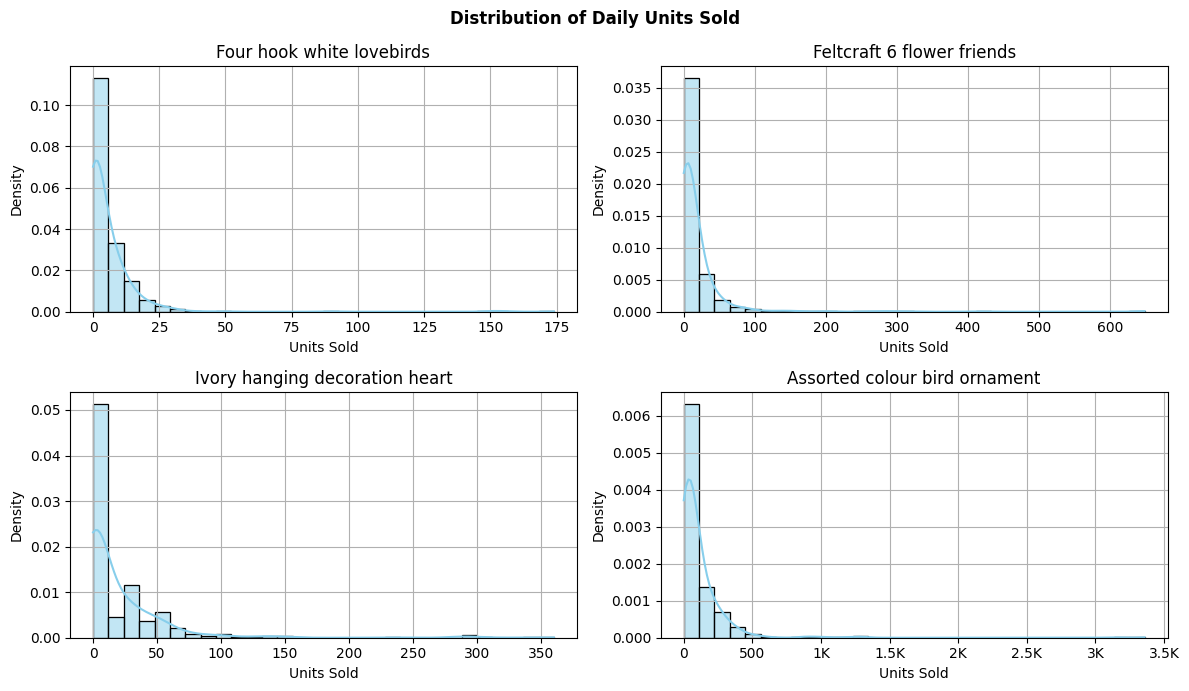

In [127]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('Distribution of Daily Units Sold', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"')['UnitsSold']

    sns.histplot(data, kde=True, ax=ax, stat='density', bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('Units Sold')
    ax.set_ylabel('Density')
    ax.grid(True)
    make_axes_human_readable(ax, axis='x')

plt.tight_layout()
plt.show()

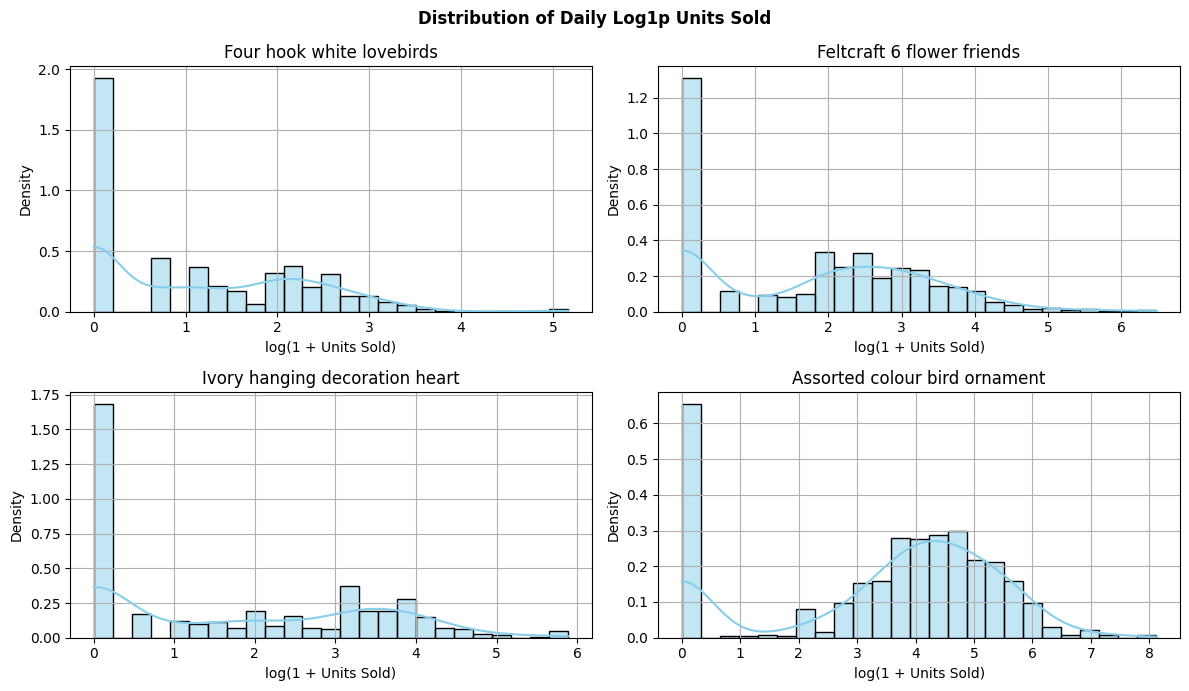

In [128]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('Distribution of Daily Log1p Units Sold', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"')['UnitsSold']

    log_data = np.log1p(data)  # log(1 + x) transformation

    sns.histplot(log_data, kde=True, ax=ax, stat='density', bins=25, color='skyblue', edgecolor='black')
    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('log(1 + Units Sold)')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

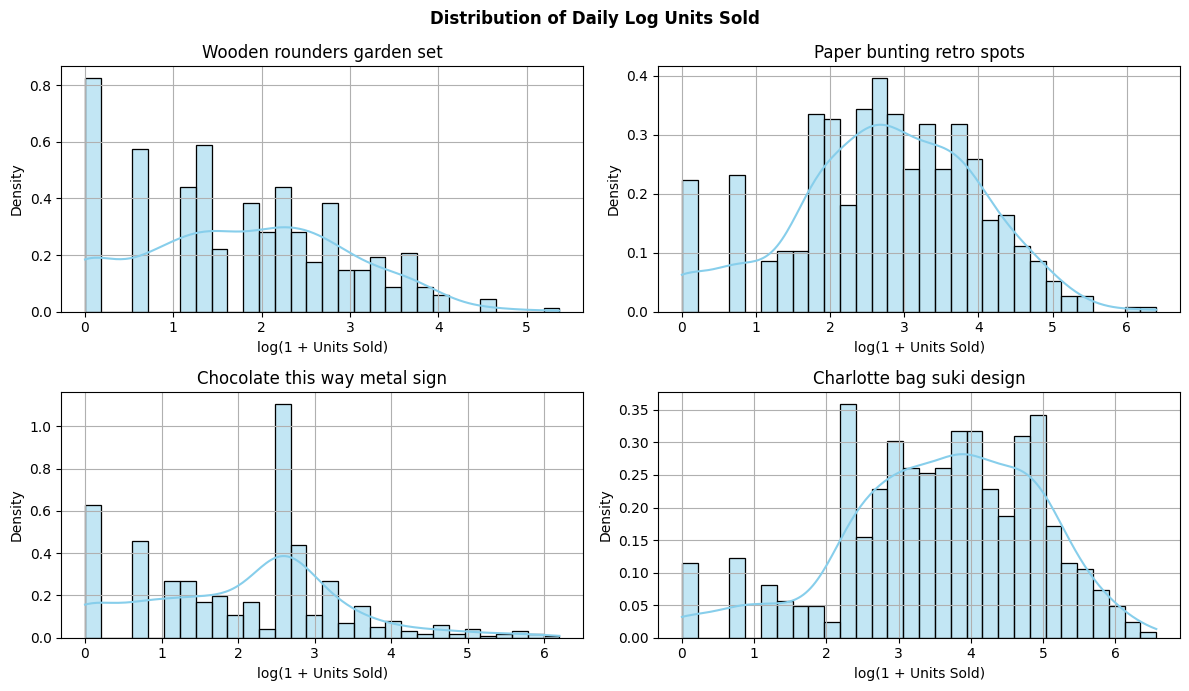

In [103]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('Distribution of Daily Log Units Sold', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"')['UnitsSold']

    log_data = np.log(data[data > 0])

    sns.histplot(log_data, kde=True, ax=ax, stat='density', bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('log(1 + Units Sold)')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

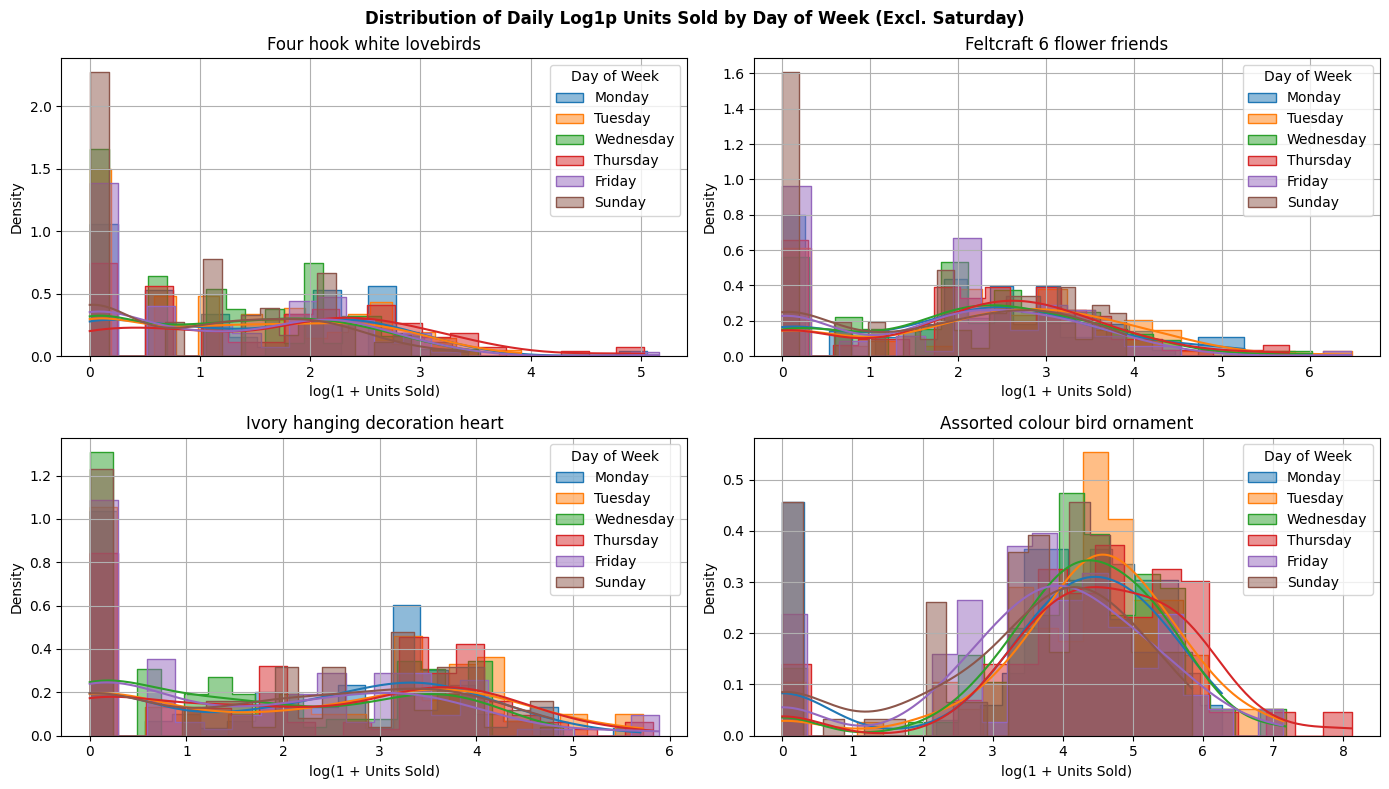

In [129]:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
palette = sns.color_palette('tab10', n_colors=len(ordered_days))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
fig.suptitle('Distribution of Daily Log1p Units Sold by Day of Week (Excl. Saturday)', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]

    product_df = online_retail_df.query(f'Description == "{product}"')[['Date', 'UnitsSold']].copy()
    product_df['DayOfWeek'] = product_df['Date'].dt.day_name()
    product_df['Log1pUnitsSold'] = np.log1p(product_df['UnitsSold'])

    for i, day in enumerate(ordered_days):
        day_data = product_df.query('DayOfWeek == @day')['Log1pUnitsSold']
        sns.histplot(
            day_data,
            kde=True,
            stat='density',
            bins=20,
            ax=ax,
            label=day,
            color=palette[i],
            element='step',
            fill=True,
        )

    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('log(1 + Units Sold)')
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend(title='Day of Week')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [130]:
top_sample_plus = top_products.sort_values().head(4).index.values
top_sample_plus

array(['charlotte bag suki design', 'pack of 72 skull cake cases',
       'victorian glass hanging tlight',
       'colour glass tlight holder hanging'], dtype=object)

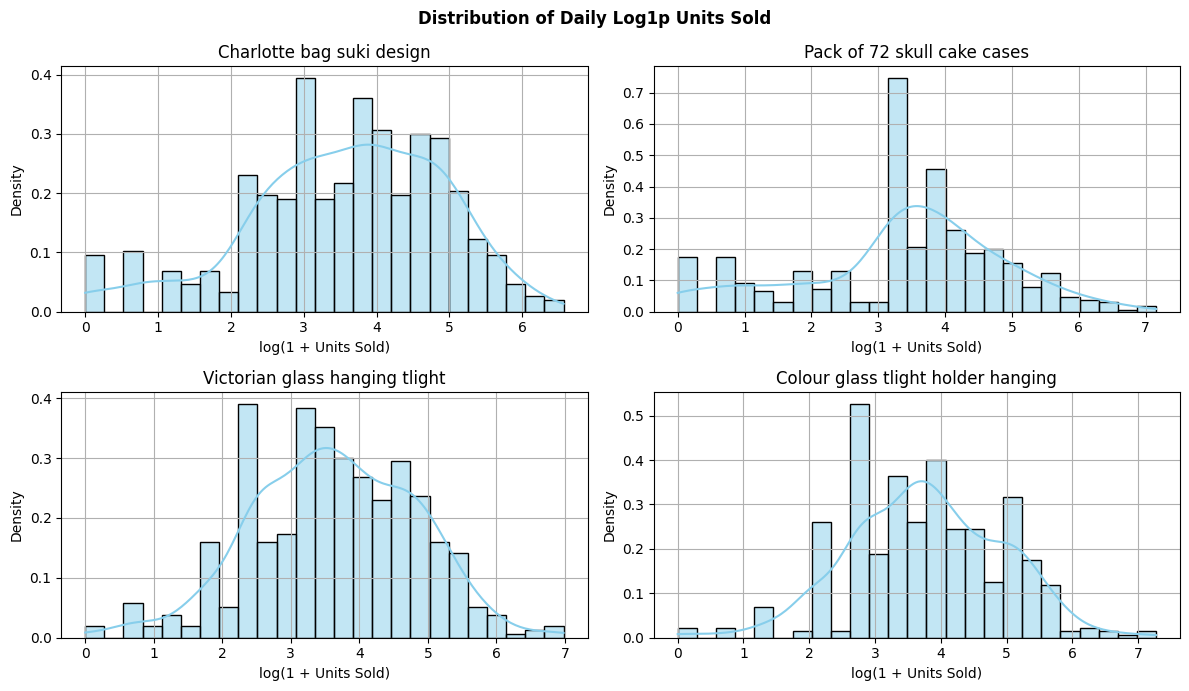

In [131]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('Distribution of Daily Log1p Units Sold', fontweight='bold')

for ax, product in zip(axs.flatten(), top_sample_plus):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"')['UnitsSold']

    log_data = np.log(data[data > 0])  # log(1 + x) transformation

    sns.histplot(log_data, kde=True, ax=ax, stat='density', bins=25, color='skyblue', edgecolor='black')
    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('log(1 + Units Sold)')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [133]:
units_sold_pivoted_df = (
    online_retail_df.pivot(
        index='Date', columns='Description', values='UnitsSold')
    .fillna(0)
)
units_sold_pivoted_df

Description,12 pencils small tube red spotty,12 pencils tall tube posy,12 pencils tall tube woodland,6 ribbons rustic charm,60 teatime fairy cake cases,72 sweetheart fairy cake cases,antique silver tea glass etched,assorted colour bird ornament,bag 500g swirly marbles,baking set 9 piece retrospot,...,wood black board ant white finish,wood s3 cabinet ant white finish,wooden frame antique white,wooden happy birthday garland,wooden picture frame white finish,wooden rounders garden set,wooden school colouring set,woodland charlotte bag,world war 2 gliders asstd designs,zinc metal heart decoration
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-01,45,69,4,27,173,50,210,1272,2,54,...,0,5,38,0,30,0,0,34,48,66
2009-12-02,87,87,21,7,159,229,122,121,210,33,...,0,10,40,0,83,0,0,20,435,254
2009-12-03,34,116,13,3,201,83,158,312,6,31,...,0,26,46,21,48,0,0,10,56,104
2009-12-04,84,160,25,2,99,3,56,258,81,66,...,0,10,19,43,8,0,0,14,144,65
2009-12-05,0,24,0,0,0,0,12,24,12,6,...,0,26,48,0,54,0,0,0,48,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,78,28,50,97,34,58,99,133,272,14,...,23,0,33,3,15,8,26,6,205,6
2011-12-06,63,14,12,24,3,4,114,240,220,74,...,4,0,8,1,8,3,0,77,243,33
2011-12-07,20,12,40,6,31,78,24,256,168,18,...,70,0,52,0,42,9,126,140,240,0


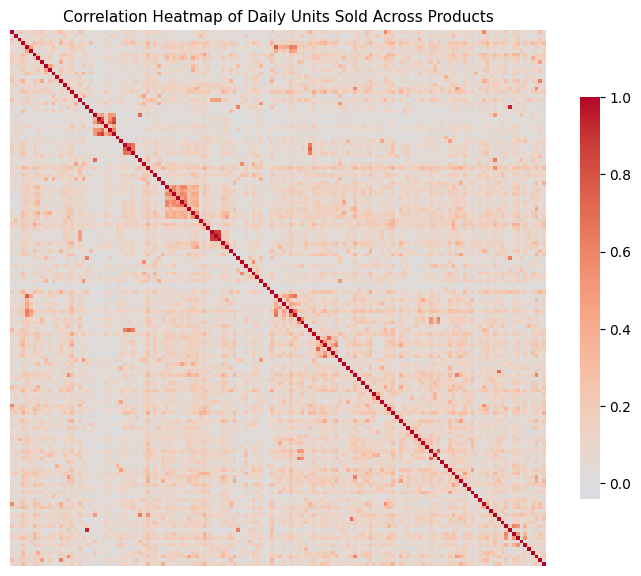

In [138]:
corr_matrix = units_sold_pivoted_df.corr()

plt.figure(figsize=(7, 7))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={'shrink': 0.6},
    xticklabels=False,
    yticklabels=False
)
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation Heatmap of Daily Units Sold Across Products', fontsize=11)
plt.tight_layout()
plt.show()

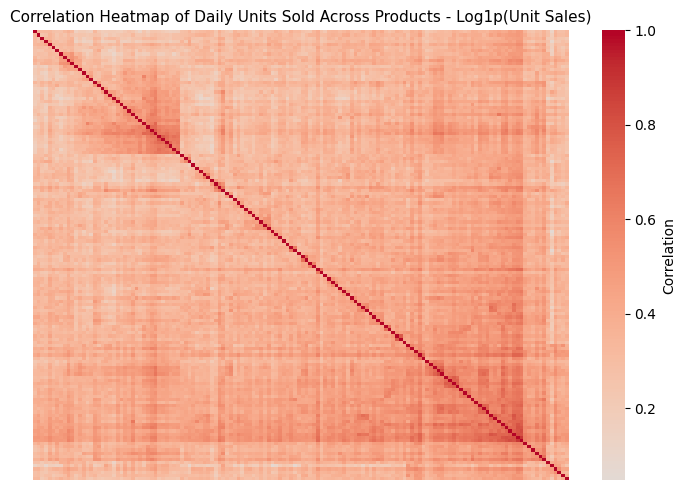

In [139]:
# Log transform to reduce skew
log_product_matrix = np.log1p(units_sold_pivoted_df)

# Correlation matrix
corr_matrix = log_product_matrix.corr()

# Hierarchical clustering to reorder rows/columns
linkage_matrix = linkage(squareform(1 - corr_matrix), method='average')
ordered_idx = leaves_list(linkage_matrix)
ordered_corr = corr_matrix.iloc[ordered_idx, ordered_idx]

# Clean heatmap without dendrogram
plt.figure(figsize=(7,5))
sns.heatmap(
    ordered_corr,
    cmap='coolwarm',
    center=0,
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation Heatmap of Daily Units Sold Across Products - Log1p(Unit Sales)', fontsize=11)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [143]:
corr_matrix.index.name = "Product A"
corr_matrix.columns.name = "Product B"

# Mask lower triangle and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Stack and filter
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Product A', 'Product B', 'Correlation']

# Filter for strong correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.75]

# Sort by strength
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Show top results
high_corr_pairs


,Product A,Product B,Correlation
4537,hanging heart zinc tlight holder,white hanging heart tlight holder,0.890499
5992,love building block word,white hanging heart tlight holder,0.817812
6356,lunchbag spaceboy design,lunchbag suki design,0.816434
4483,hanging heart zinc tlight holder,pack of 72 retro spot cake cases,0.812607
7786,pack of 72 retro spot cake cases,white hanging heart tlight holder,0.809994
994,assorted colour bird ornament,hanging heart zinc tlight holder,0.805133
4460,hanging heart zinc tlight holder,love building block word,0.793718
4458,hanging heart zinc tlight holder,jumbo storage bag skulls,0.793168
1086,assorted colour bird ornament,white hanging heart tlight holder,0.792065
627,60 teatime fairy cake cases,pack of 72 retro spot cake cases,0.791449


In [144]:
# Create graph: nodes = products, edges = strong correlations
G = nx.Graph()

# Add edges from high_corr_pairs (already filtered to r > 0.8)
for _, row in high_corr_pairs.iterrows():
    G.add_edge(row['Product A'], row['Product B'], weight=row['Correlation'])

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

# Print cluster sizes
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i} ({len(cluster)} products): {sorted(cluster)}")

Cluster 1 (9 products): ['60 teatime fairy cake cases', 'assorted colour bird ornament', 'hanging heart zinc tlight holder', 'jumbo storage bag skulls', 'love building block word', 'pack of 60 pink paisley cake cases', 'pack of 72 retro spot cake cases', 'strawberry ceramic trinket box', 'white hanging heart tlight holder']
Cluster 2 (2 products): ['lunchbag spaceboy design', 'lunchbag suki design']
Cluster 3 (2 products): ['red spot ceramic drawer knob', 'white spot red ceramic drawer knob']
Cluster 4 (2 products): ['plasters in tin spaceboy', 'plasters in tin woodland animals']
Cluster 5 (4 products): ['charlotte bag suki design', 'red spotty charlotte bag', 'strawberry charlotte bag', 'woodland charlotte bag']
Cluster 6 (2 products): ['6 ribbons rustic charm', 'regency cakestand 3 tier']


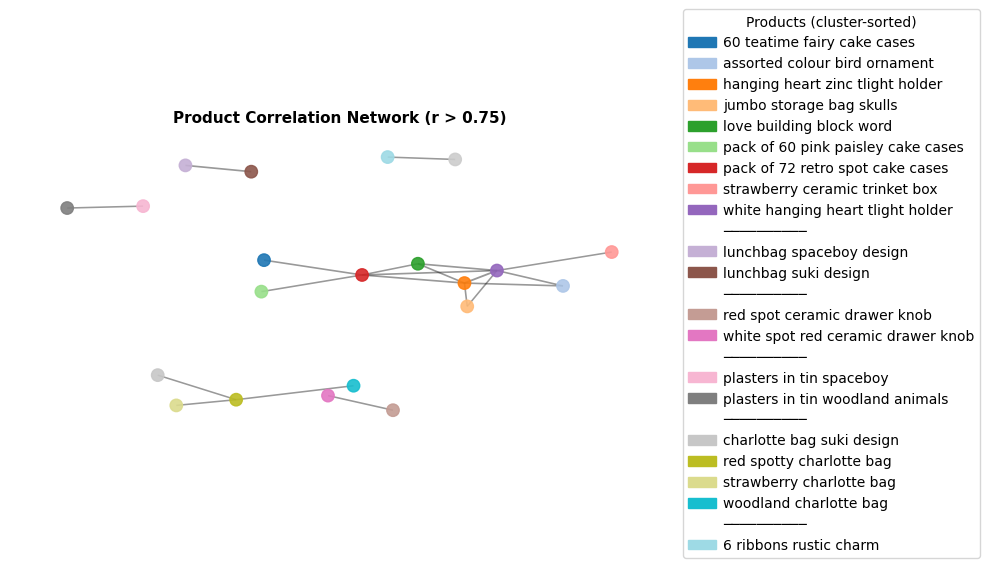

In [146]:
# Extract clusters
clusters = list(nx.connected_components(G))

# Flatten product list (product, cluster_id), sorted by cluster then name
clustered_products = []
for cluster_id, cluster in enumerate(clusters):
    for product in sorted(cluster):
        clustered_products.append((product, cluster_id))

# Limit to top N products
N = 20
top_products = clustered_products[:N]

# Assign distinct colors
tab20 = plt.get_cmap('tab20').colors
product_colors = {
    product: tab20[i % len(tab20)] for i, (product, _) in enumerate(top_products)
}
default_color = (0.8, 0.8, 0.8)

# Compute layout
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw graph
plt.figure(figsize=(10, 5))
node_colors = [product_colors.get(node, default_color) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80, alpha=0.9)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    width=[G[u][v]['weight'] * 1.5 for u, v in G.edges()],
    alpha=0.4
)

# Build legend entries, adding separator between cluster transitions
legend_handles = []
last_cluster = None
for product, cluster_id in top_products:
    if last_cluster is not None and cluster_id != last_cluster:
        # Add a separator (a transparent patch with a line as the label)
        legend_handles.append(
            mpatches.Patch(color='none', label='──────────')  # separator line
        )
    legend_handles.append(
        mpatches.Patch(color=product_colors[product], label=product)
    )
    last_cluster = cluster_id

plt.legend(
    handles=legend_handles,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title='Products (cluster-sorted)',
    handletextpad=0.5,
    borderaxespad=1
)

plt.title("Product Correlation Network (r > 0.75)", fontsize=11, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

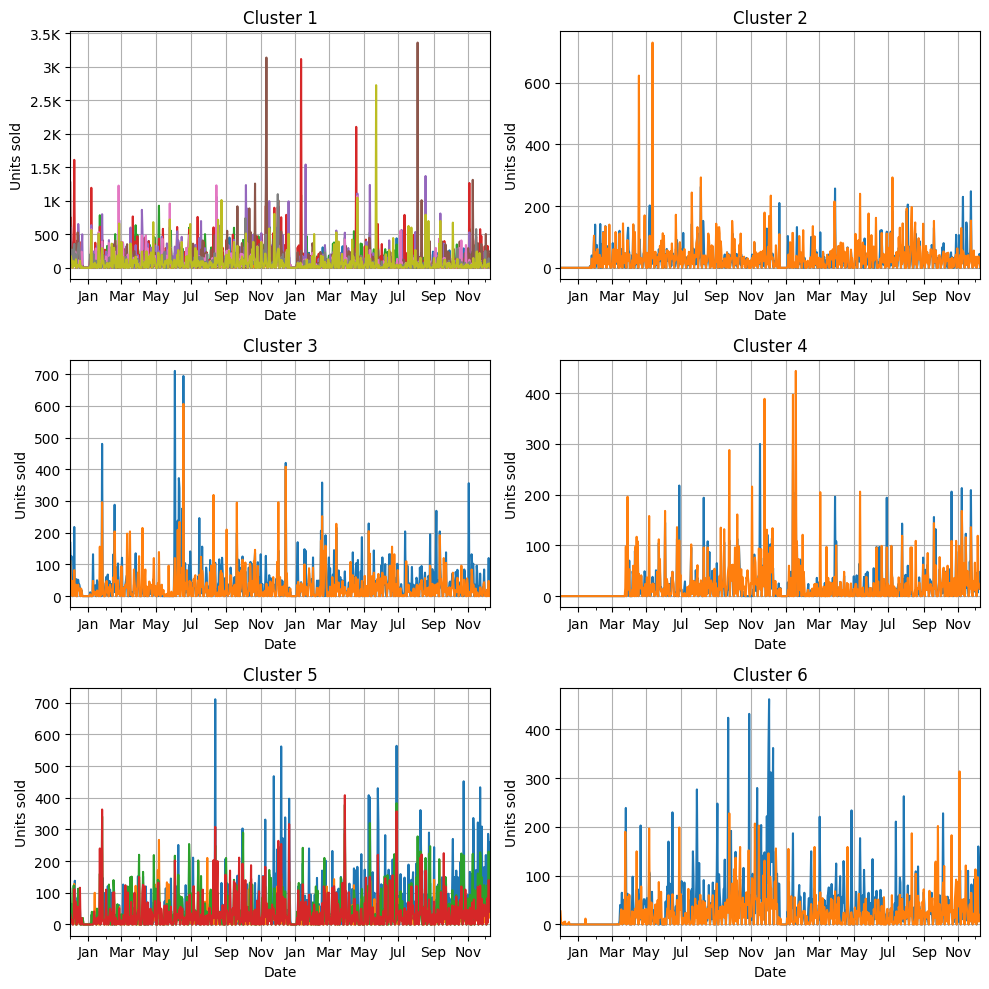

In [148]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for i, (ax, cluster) in enumerate(zip(axs.flatten(), clusters), start=1):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i}')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # e.g., 'Jan 2010'
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 2 months
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

In [149]:
corr_matrix.index.name = "Product A"
corr_matrix.columns.name = "Product B"

# Mask lower triangle and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Stack and filter
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Product A', 'Product B', 'Correlation']

# Filter for strong correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.5]

# Sort by strength
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Create graph: nodes = products, edges = strong correlations
G = nx.Graph()

# Add edges from high_corr_pairs (already filtered to r > 0.8)
for _, row in high_corr_pairs.iterrows():
    G.add_edge(row['Product A'], row['Product B'], weight=row['Correlation'])

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

# Print cluster sizes
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i} ({len(cluster)} products): {sorted(cluster)}")

Cluster 1 (140 products): ['12 pencils small tube red spotty', '12 pencils tall tube posy', '12 pencils tall tube woodland', '6 ribbons rustic charm', '60 teatime fairy cake cases', '72 sweetheart fairy cake cases', 'antique silver tea glass etched', 'assorted colour bird ornament', 'bag 500g swirly marbles', 'baking set 9 piece retrospot', 'baking set spaceboy design', 'bathroom metal sign', 'blue happy birthday bunting', 'blue harmonica in box', 'box of 24 cocktail parasols', 'charlotte bag suki design', 'childs apron spaceboy design', 'chocolate this way metal sign', 'colour glass tlight holder hanging', 'cook with wine metal sign', 'cream heart card holder', 'door mat fairy cake', 'door mat new england', 'door mat spotty home sweet home', 'door mat union flag', 'doormat hearts', 'edwardian parasol natural', 'fancy font birthday card', 'feltcraft 6 flower friends', 'feltcraft butterfly hearts', 'feltcraft cushion owl', 'four hook white lovebirds', 'gin tonic diet metal sign', 'hand 

In [150]:
sales_matrix = (
    online_retail_df
    .pivot(index='Date', columns='Description', values='UnitsSold')
    .sort_index()
    .apply(np.log1p)  # log-transform to reduce skew
)

price_matrix = (
    online_retail_df
    .pivot(index='Date', columns='Description', values='AveragePricePerUnitPounds')
    .sort_index()
)

# Combine explanatory variables into one DataFrame
exog_df = pd.concat([
    uk_daily_cci.rename('CCI'),
    uk_daily_cpi.rename('CPI'),
    uk_daily_interest_rate.rename('InterestRate'),
    uk_daily_unemployment.rename('Unemployment'),
], axis=1)

In [158]:
lag_features = {}

for product in sales_matrix.columns:
    series = sales_matrix[product]
    df = pd.DataFrame({
        'Sales': series,
        'Lag_1': series.shift(1),
        'Lag_7': series.shift(7),
        'Lag_30': series.shift(30),
        'Roll_3': series.rolling(3).mean(),
        'Roll_7': series.rolling(7).mean(),
        'Roll_30': series.rolling(30).mean(),
    })

    df = df.join(pd.concat([
        uk_daily_cci.rename('CCI'),
        uk_daily_cpi.rename('CPI'),
        uk_daily_interest_rate.rename('InterestRate'),
        uk_daily_unemployment.rename('Unemployment'),
        online_retail_df[online_retail_df['Description'] == product]
            .set_index('Date')['AveragePricePerUnitPounds']
            .rename('Price')
    ], axis=1), how='left')

    df = df.dropna()

    if not df.empty:
        lag_features[product] = df.corr().loc[
            ['CCI', 'CPI', 'InterestRate', 'Unemployment', 'Price', 'Lag_1', 'Lag_7', 'Lag_30', 'Roll_3', 'Roll_7', 'Roll_30'],
            'Sales'
        ]

correlation_df = pd.DataFrame.from_dict(lag_features, orient='index')
correlation_df

,CCI,CPI,InterestRate,Unemployment,Price,Lag_1,Lag_7,Lag_30,Roll_3,Roll_7,Roll_30
12 pencils small tube red spotty,-0.088779,0.067630,0.069669,0.031943,-0.225835,0.238115,0.407218,0.027794,0.674280,0.510291,0.403965
12 pencils tall tube posy,-0.101723,0.037488,-0.005066,0.223535,-0.209173,0.126520,0.303924,-0.013962,0.647045,0.488681,0.376278
12 pencils tall tube woodland,-0.104957,0.072856,0.031622,0.087411,-0.149386,0.134459,0.389220,0.017100,0.640702,0.490640,0.390192
6 ribbons rustic charm,-0.262981,0.265568,0.229497,0.110036,-0.301222,0.354190,0.583659,0.070359,0.700478,0.572394,0.502026
60 teatime fairy cake cases,0.176184,-0.195812,-0.187023,-0.110192,-0.296090,0.116052,0.481223,-0.020676,0.614088,0.412254,0.299699
...,...,...,...,...,...,...,...,...,...,...,...
wooden rounders garden set,-0.038255,0.106139,0.059075,-0.090344,-0.199572,0.451546,0.593048,0.152417,0.771670,0.667731,0.575157
wooden school colouring set,-0.197173,0.173033,0.124543,0.111522,-0.009873,0.258635,0.471485,0.113292,0.697297,0.566316,0.466205
woodland charlotte bag,-0.082256,0.072568,0.029420,0.052094,0.007501,0.104417,0.430551,-0.103284,0.586532,0.364070,0.211637
world war 2 gliders asstd designs,-0.114360,0.105091,0.075114,0.114114,-0.120906,0.097051,0.299564,-0.043955,0.608800,0.415530,0.291414


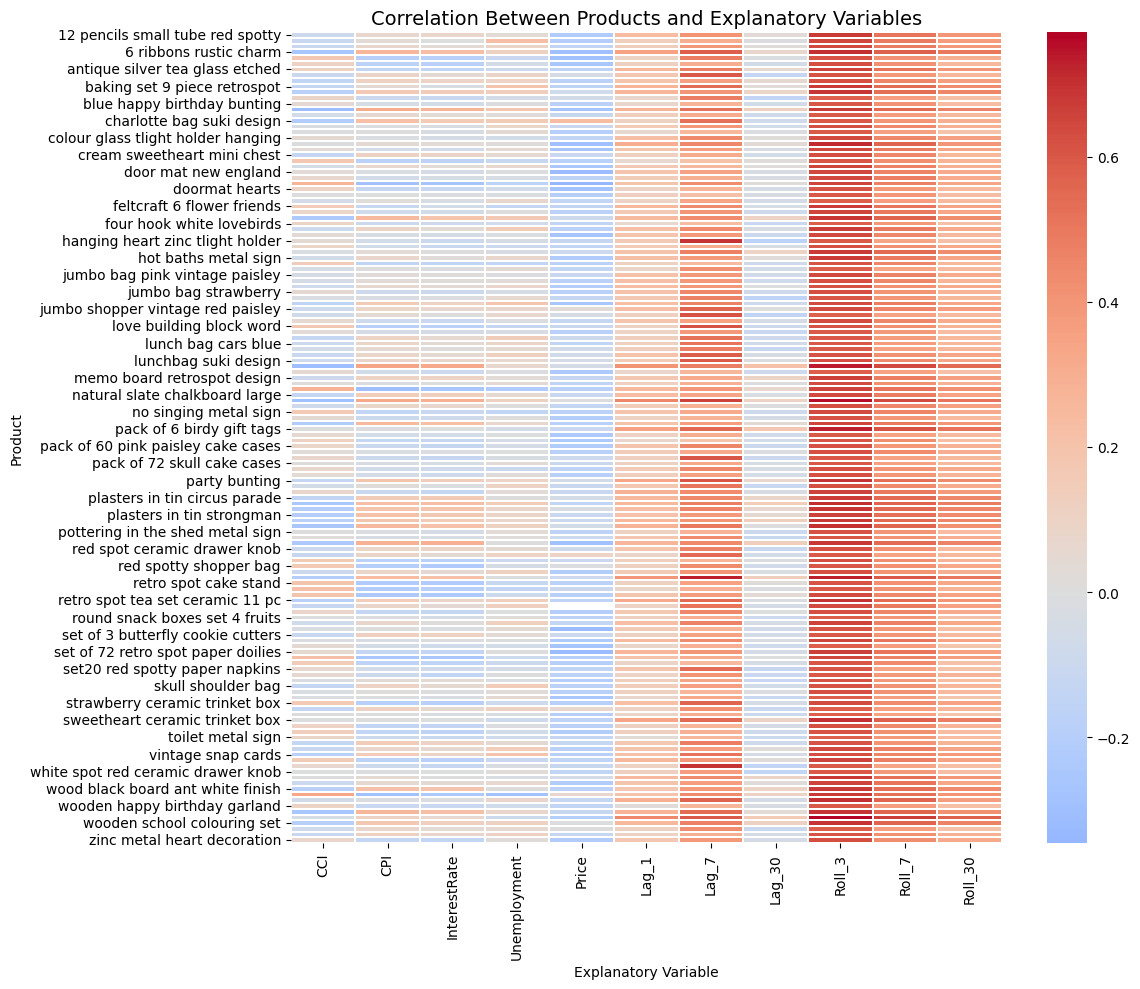

In [159]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, cmap='coolwarm', center=0, linewidths=0.1)

plt.title("Correlation Between Products and Explanatory Variables", fontsize=14)
plt.xlabel("Explanatory Variable")
plt.ylabel("Product")
plt.tight_layout()
plt.show()